In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyprojroot import here
import os
import numpy as np
import celltypist

import scanpy as sc
import squidpy as sq
import spatialdata as sd
from spatialdata_io import xenium

In [2]:
xe_obj = xenium(os.path.join(here('02_data/01_raw-data/5000_genes/xenium')))


INFO     reading                                                                                                   
         /fh/fast/_IRC/FHIL/grp/analyses/xenium_cell_annotation/02_data/01_raw-data/5000_genes/xenium/cell_feature_
         matrix.h5                                                                                                 


/loc/scratch/26236806/ipykernel_13081/374346618.py:1: DeprecationWarning: The default value of `cells_as_circles` will change to `False` in the next release. Please pass `True` explicitly to maintain the current behavior.
  xe_obj = xenium(os.path.join(here('02_data/01_raw-data/5000_genes/xenium')))


In [62]:
xe_obj.tables['table'].obs.head()

,cell_id,transcript_counts,control_probe_counts,genomic_control_counts,control_codeword_counts,unassigned_codeword_counts,deprecated_codeword_counts,total_counts,cell_area,nucleus_area,nucleus_count,segmentation_method,region,z_level,cell_labels,group,leiden
0,aaaaebmm-1,303,0,0,0,0,31,334,44.659533,31.835157,1.0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...,cell_circles,0.0,1,Proliferative Tumor Cells,8
1,aaaafhpp-1,311,0,0,0,0,28,339,57.664533,38.247345,1.0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...,cell_circles,0.0,2,Tumor Cells,0
2,aaaahcem-1,301,0,0,0,0,32,333,39.827814,27.590470,1.0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...,cell_circles,0.0,3,Proliferative Tumor Cells,8
3,aaaakeoi-1,369,0,0,0,0,58,427,60.870627,38.879533,1.0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...,cell_circles,0.0,4,Proliferative Tumor Cells,8
4,aaaalald-1,295,0,0,0,0,47,342,50.484689,46.510939,1.0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...,cell_circles,0.0,5,Tumor Cells,1


In [29]:
xe_annotations = pd.read_csv(here('02_data/01_raw-data/5000_genes/xenium/Xenium_Prime_Ovarian_Cancer_FFPE_XRrun_cell_groups.csv'), header=0)
xe_obj.tables['table'].obs = pd.merge(
    xe_obj.tables['table'].obs,
    xe_annotations.rename(columns={'Barcode': 'cell_id'}), 
    on='cell_id',
    how='left'
)
xe_obj.obs.head()


,cell_id,transcript_counts,control_probe_counts,genomic_control_counts,control_codeword_counts,unassigned_codeword_counts,deprecated_codeword_counts,total_counts,cell_area,nucleus_area,nucleus_count,segmentation_method,region,z_level,cell_labels,group
0,aaaaebmm-1,303,0,0,0,0,31,334,44.659533,31.835157,1.0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...,cell_circles,0.0,1,Proliferative Tumor Cells
1,aaaafhpp-1,311,0,0,0,0,28,339,57.664533,38.247345,1.0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...,cell_circles,0.0,2,Tumor Cells
2,aaaahcem-1,301,0,0,0,0,32,333,39.827814,27.590470,1.0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...,cell_circles,0.0,3,Proliferative Tumor Cells
3,aaaakeoi-1,369,0,0,0,0,58,427,60.870627,38.879533,1.0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...,cell_circles,0.0,4,Proliferative Tumor Cells
4,aaaalald-1,295,0,0,0,0,47,342,50.484689,46.510939,1.0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...,cell_circles,0.0,5,Tumor Cells


In [31]:
xe_data = xe_obj.tables['table']

In [5]:
sc_data = sc.read_10x_h5(os.path.join(here('02_data/01_raw-data/5000_genes/sc/17k_Ovarian_Cancer_scFFPE_count_filtered_feature_bc_matrix.h5')), )


In [6]:
sc_data.var_names_make_unique()

In [7]:
sc_annotations = pd.read_csv(os.path.join(here('02_data/01_raw-data/5000_genes/sc/FLEX_Ovarian_Barcode_Cluster_Annotation.csv')))
sc_data.obs = pd.merge(
    sc_data.obs,
    sc_annotations, 
    left_index=True,
    right_on='Barcode',
    how='left'
).set_index('Barcode')
sc_data.obs.head()

,Cell Annotation
Barcode,
AAACAAGCAAAGGTAAACTTTAGG-1,Tumor Associated Fibroblasts
AAACAAGCAAATCACGACTTTAGG-1,Endothelial Cells
AAACAAGCAACTTGTCACTTTAGG-1,Stromal Associated Fibroblasts
AAACAAGCAAGGCCTGACTTTAGG-1,Tumor Associated Fibroblasts
AAACAAGCACATTCGTACTTTAGG-1,Tumor Associated Fibroblasts


## subset SC to spatial genes

In [8]:
spatial_gene_panel = xe_data.var.index.to_list()
len(spatial_gene_panel)

5101

In [9]:
sc_data.var.index.to_list()[-5:]

['MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB']

In [10]:
shared_genes = [x for x in spatial_gene_panel if x in sc_data.var.index.to_list()]
len(shared_genes)

4912

In [11]:
len([x for x in spatial_gene_panel if x not in sc_data.var.index.to_list()])
[x for x in spatial_gene_panel if x not in sc_data.var.index.to_list()][1:10]

['ACRBP',
 'ALDOA',
 'AMIGO3',
 'ANGPT2',
 'AP5B1',
 'APLF',
 'BCAR4',
 'BNIP3',
 'C4A']

In [12]:
sc_data_filtered = sc_data[:,[x for x in xe_data.var.index.to_list() if x in sc_data.var.index.to_list()]]
sc_data_filtered = sc_data_filtered[~sc_data_filtered.obs['Cell Annotation'].isna(),]
sc_data_filtered

View of AnnData object with n_obs × n_vars = 17050 × 4912
    obs: 'Cell Annotation'
    var: 'gene_ids', 'feature_types', 'genome'

In [13]:
sc_data_filtered.n_obs

17050

In [14]:
# sc_data.layers["counts"] = sc_data.X.copy()
sc.pp.normalize_total(sc_data_filtered, target_sum=1e4)
sc.pp.log1p(sc_data_filtered)

In [15]:
num_cells = sc_data_filtered.n_obs
test_ratio = 0.2  # 20% for testing
test_indices = np.random.choice(num_cells, size=int(num_cells * test_ratio), replace=False)
train_indices = np.array([i for i in range(num_cells) if i not in test_indices])

sc_data_filtered_train = sc_data_filtered[train_indices, :].copy()
sc_data_filtered_test = sc_data_filtered[test_indices, :].copy()

In [16]:
model = celltypist.train(sc_data_filtered_train, 'Cell Annotation')

🍳 Preparing data before training
✂️ 54 non-expressed genes are filtered out
🔬 Input data has 13640 cells and 4858 genes
⚖️ Scaling input data
🏋️ Training data using logistic regression
✅ Model training done!


In [17]:
test_predictions = celltypist.annotate(sc_data_filtered_test, model, majority_voting = True)

🔬 Input data has 3410 cells and 4912 genes
🔗 Matching reference genes in the model
🧬 4858 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


In [18]:
test_predictions.predicted_labels

,predicted_labels,over_clustering,majority_voting
Barcode,,,
CGTGTTTCATGGCTAAACTTTAGG-1,Proliferative Tumor Cells,0,Proliferative Tumor Cells
TCGAAGTAGTTATTGCACTTTAGG-2,Proliferative Tumor Cells,2,VEGFA+ Tumor Cells
GGGTTATAGTCAGGCAACTTTAGG-1,VEGFA+ Tumor Cells,3,"MT-High, Jun+/Fos+ Tumor Cells"
GGGAGTGAGTTGCGGAACTTTAGG-1,Tumor Cells,4,Tumor Cells
ACTTGAAAGTGATTAGACTTTAGG-1,"MT-High, Jun+/Fos+ Tumor Cells",4,Tumor Cells
...,...,...,...
TCGAACCTCAAGCGATACTTTAGG-2,Macrophages,17,Macrophages
TAGCGCGCAAGTAAGAACTTTAGG-1,Smooth Muscle Cells,26,Smooth Muscle Cells
TATGCATTCAACCGGAACTTTAGG-1,Pericytes,35,Pericytes


In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


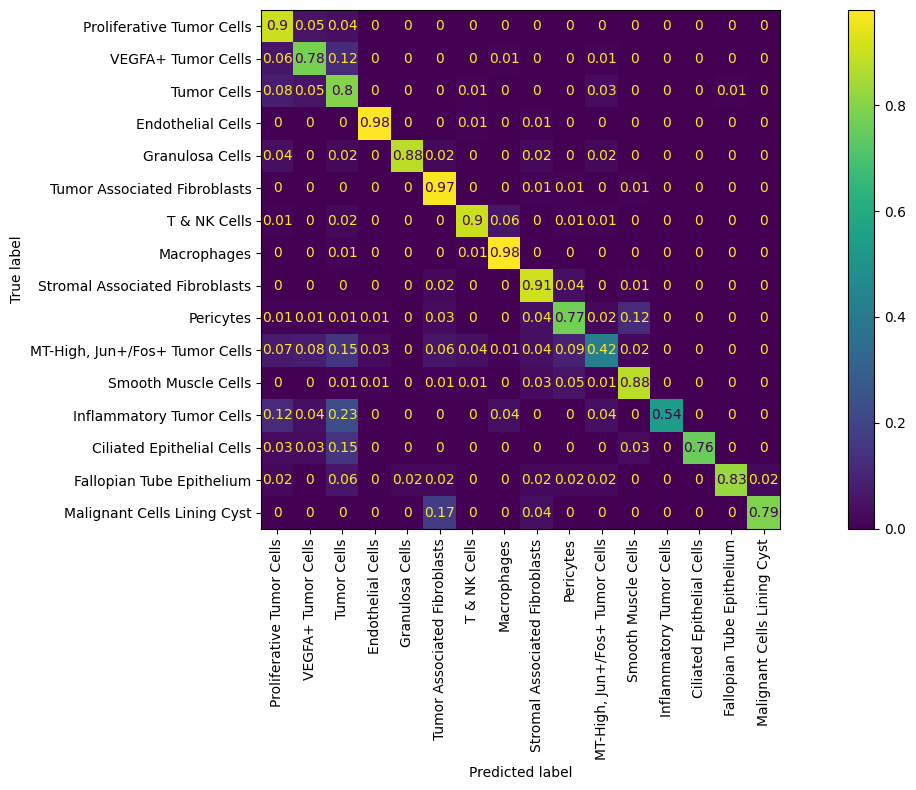

In [20]:
cm = confusion_matrix(sc_data_filtered_test.obs['Cell Annotation'], test_predictions.predicted_labels['predicted_labels'],
                             labels=sc_data_filtered_test.obs['Cell Annotation'].unique(), normalize='true')
fig, ax = plt.subplots(figsize=(14, 8))
disp = ConfusionMatrixDisplay(confusion_matrix = cm.round(2),
                             display_labels=sc_data_filtered_test.obs['Cell Annotation'].unique())
disp.plot(ax=ax)
ax.tick_params(axis='x', labelrotation=90)
# ax.set_yticklabels(y_true.cat.categories)
plt.tight_layout()
plt.show()

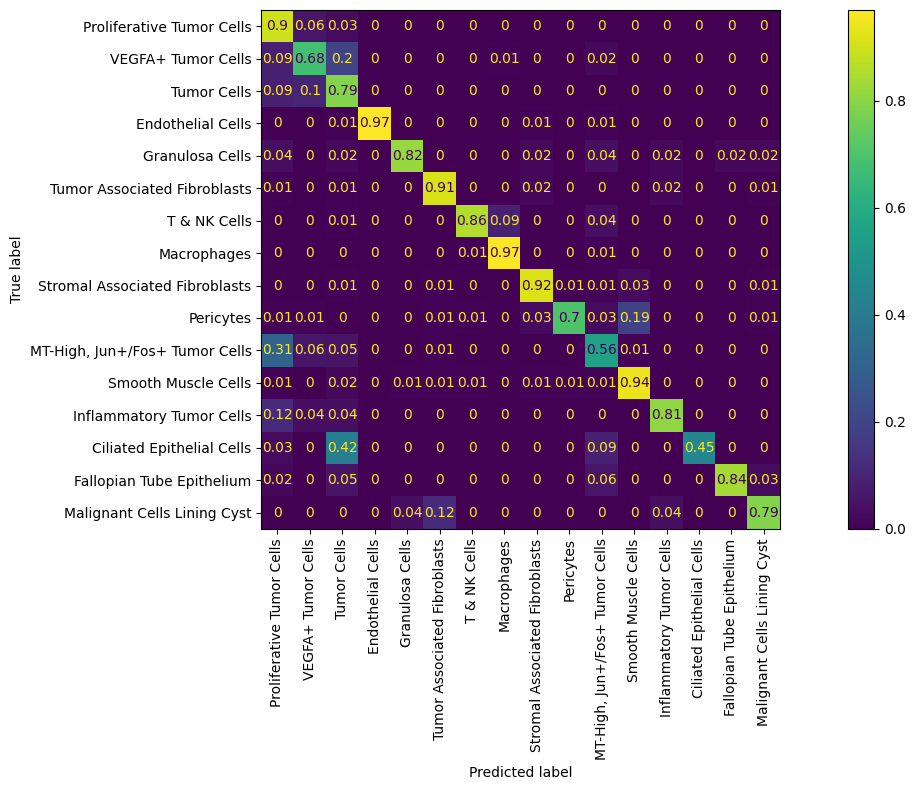

In [21]:
cm = confusion_matrix(sc_data_filtered_test.obs['Cell Annotation'], test_predictions.predicted_labels['majority_voting'],
                             labels=sc_data_filtered_test.obs['Cell Annotation'].unique(), normalize='true')

fig, ax = plt.subplots(figsize=(14, 8))
disp = ConfusionMatrixDisplay(confusion_matrix = cm.round(2),
                             display_labels=sc_data_filtered_test.obs['Cell Annotation'].unique())
disp.plot(ax=ax)
ax.tick_params(axis='x', labelrotation=90)
# ax.set_yticklabels(y_true.cat.categories)
plt.tight_layout()
plt.show()

In [22]:
from sklearn.metrics import classification_report
print(classification_report(sc_data_filtered_test.obs['Cell Annotation'], test_predictions.predicted_labels['majority_voting']))

                                precision    recall  f1-score   support

     Ciliated Epithelial Cells       1.00      0.45      0.62        33
             Endothelial Cells       0.99      0.97      0.98       280
     Fallopian Tube Epithelium       0.96      0.84      0.90        63
               Granulosa Cells       0.93      0.82      0.87        49
      Inflammatory Tumor Cells       0.62      0.81      0.70        26
MT-High, Jun+/Fos+ Tumor Cells       0.63      0.56      0.60       117
                   Macrophages       0.96      0.97      0.96       469
   Malignant Cells Lining Cyst       0.63      0.79      0.70        24
                     Pericytes       0.95      0.70      0.81       172
     Proliferative Tumor Cells       0.76      0.90      0.83       404
           Smooth Muscle Cells       0.80      0.94      0.87       188
Stromal Associated Fibroblasts       0.94      0.92      0.93       287
                  T & NK Cells       0.94      0.86      0.89  

In [33]:
xe_data.layers["counts"] = xe_data.X.copy()
sc.pp.normalize_total(xe_data, target_sum=1e4)
sc.pp.log1p(xe_data)

In [34]:
xe_predictions = celltypist.annotate(xe_data, model, majority_voting=True)

🔬 Input data has 407124 cells and 5101 genes
🔗 Matching reference genes in the model
🧬 4858 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 30
🗳️ Majority voting the predictions
✅ Majority voting done!


In [36]:
xe_data.obs['group'][xe_data.obs['group'].isna()] = 'unknown'

/loc/scratch/26236806/ipykernel_13081/2714874226.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xe_data.obs['group'][xe_data.obs['group'].isna()] = 'unknown'


In [37]:
xe_data.obs['group']

0              Proliferative Tumor Cells
1                            Tumor Cells
2              Proliferative Tumor Cells
3              Proliferative Tumor Cells
4                            Tumor Cells
                       ...              
407119    Stromal Associated Fibroblasts
407120              SOX2-OT+ Tumor Cells
407121                           unknown
407122                           unknown
407123              SOX2-OT+ Tumor Cells
Name: group, Length: 407124, dtype: object

In [38]:
xe_predictions.predicted_labels['majority_voting'].unique()
# cm.shape

['MT-High, Jun+/Fos+ Tumor Cells', 'Macrophages', 'Ciliated Epithelial Cells', 'T & NK Cells', 'Tumor Associated Fibroblasts', ..., 'Granulosa Cells', 'Malignant Cells Lining Cyst', 'Smooth Muscle Cells', 'Pericytes', 'Fallopian Tube Epithelium']
Length: 12
Categories (12, object): ['Ciliated Epithelial Cells', 'Endothelial Cells', 'Fallopian Tube Epithelium', 'Granulosa Cells', ..., 'Smooth Muscle Cells', 'Stromal Associated Fibroblasts', 'T & NK Cells', 'Tumor Associated Fibroblasts']

In [39]:
y_pred = xe_predictions.predicted_labels['majority_voting']
y_true = pd.Series(xe_data.obs['group'], dtype='category')
y_true

0              Proliferative Tumor Cells
1                            Tumor Cells
2              Proliferative Tumor Cells
3              Proliferative Tumor Cells
4                            Tumor Cells
                       ...              
407119    Stromal Associated Fibroblasts
407120              SOX2-OT+ Tumor Cells
407121                           unknown
407122                           unknown
407123              SOX2-OT+ Tumor Cells
Name: group, Length: 407124, dtype: category
Categories (19, object): ['Ciliated Epithelial Cells', 'Fallopian Tube Epithelium', 'Granulosa Cells', 'Inflammatory Tumor Cells', ..., 'Tumor Cells', 'Unassigned', 'VEGFA+ Tumor Cells', 'unknown']

In [40]:
labels = y_true.cat.categories.union(set(y_pred.cat.categories))
cm = confusion_matrix(xe_data.obs['group'], xe_predictions.predicted_labels['predicted_labels'], normalize='true', labels=labels)
cm = cm.round(2)

In [41]:
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Slice: keep only true classes as rows, predicted classes as columns
cm_df = cm_df.loc[y_true.cat.categories, y_pred.cat.categories]

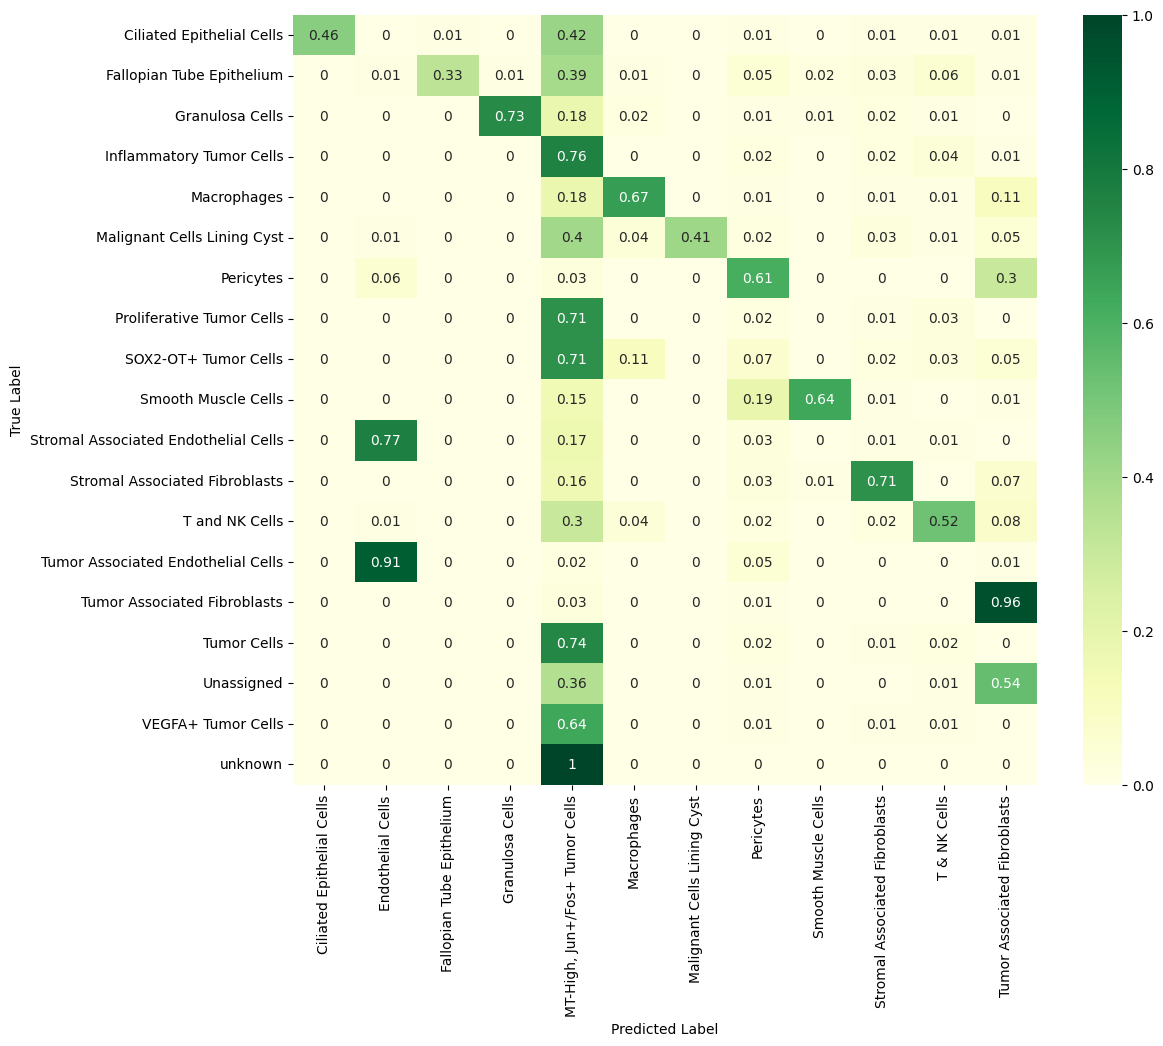

In [42]:
plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, annot=True, cmap="YlGn", xticklabels=y_pred.cat.categories, yticklabels=y_true.cat.categories)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Plot spatial data umap

In [43]:
sc.pp.pca(xe_data)

In [44]:
xe_data

AnnData object with n_obs × n_vars = 407124 × 5101
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'group'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs', 'log1p', 'neighbors', 'over_clustering', 'pca'
    obsm: 'spatial', 'X_pca'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [45]:
sc.pp.neighbors(xe_data)

In [46]:
sc.tl.umap(xe_data)

In [47]:
sc.tl.leiden(xe_data)

In [60]:
xe_data.obs.head()

,cell_id,transcript_counts,control_probe_counts,genomic_control_counts,control_codeword_counts,unassigned_codeword_counts,deprecated_codeword_counts,total_counts,cell_area,nucleus_area,nucleus_count,segmentation_method,region,z_level,cell_labels,group,leiden
0,aaaaebmm-1,303,0,0,0,0,31,334,44.659533,31.835157,1.0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...,cell_circles,0.0,1,Proliferative Tumor Cells,8
1,aaaafhpp-1,311,0,0,0,0,28,339,57.664533,38.247345,1.0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...,cell_circles,0.0,2,Tumor Cells,0
2,aaaahcem-1,301,0,0,0,0,32,333,39.827814,27.590470,1.0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...,cell_circles,0.0,3,Proliferative Tumor Cells,8
3,aaaakeoi-1,369,0,0,0,0,58,427,60.870627,38.879533,1.0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...,cell_circles,0.0,4,Proliferative Tumor Cells,8
4,aaaalald-1,295,0,0,0,0,47,342,50.484689,46.510939,1.0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...,cell_circles,0.0,5,Tumor Cells,1


In [64]:
xe_data.obs = pd.merge(
    xe_data.obs,
    xe_predictions.predicted_labels,
    left_index=True, right_index=True,
    how='left'
)
xe_data.obs.head()

,cell_id,transcript_counts,control_probe_counts,genomic_control_counts,control_codeword_counts,unassigned_codeword_counts,deprecated_codeword_counts,total_counts,cell_area,nucleus_area,nucleus_count,segmentation_method,region,z_level,cell_labels,group,leiden,predicted_labels,over_clustering,majority_voting
0,aaaaebmm-1,303,0,0,0,0,31,334,44.659533,31.835157,1.0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...,cell_circles,0.0,1,Proliferative Tumor Cells,8,Pericytes,0,"MT-High, Jun+/Fos+ Tumor Cells"
1,aaaafhpp-1,311,0,0,0,0,28,339,57.664533,38.247345,1.0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...,cell_circles,0.0,2,Tumor Cells,0,"MT-High, Jun+/Fos+ Tumor Cells",13,"MT-High, Jun+/Fos+ Tumor Cells"
2,aaaahcem-1,301,0,0,0,0,32,333,39.827814,27.590470,1.0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...,cell_circles,0.0,3,Proliferative Tumor Cells,8,Proliferative Tumor Cells,38,"MT-High, Jun+/Fos+ Tumor Cells"
3,aaaakeoi-1,369,0,0,0,0,58,427,60.870627,38.879533,1.0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...,cell_circles,0.0,4,Proliferative Tumor Cells,8,"MT-High, Jun+/Fos+ Tumor Cells",50,"MT-High, Jun+/Fos+ Tumor Cells"
4,aaaalald-1,295,0,0,0,0,47,342,50.484689,46.510939,1.0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...,cell_circles,0.0,5,Tumor Cells,1,"MT-High, Jun+/Fos+ Tumor Cells",34,"MT-High, Jun+/Fos+ Tumor Cells"


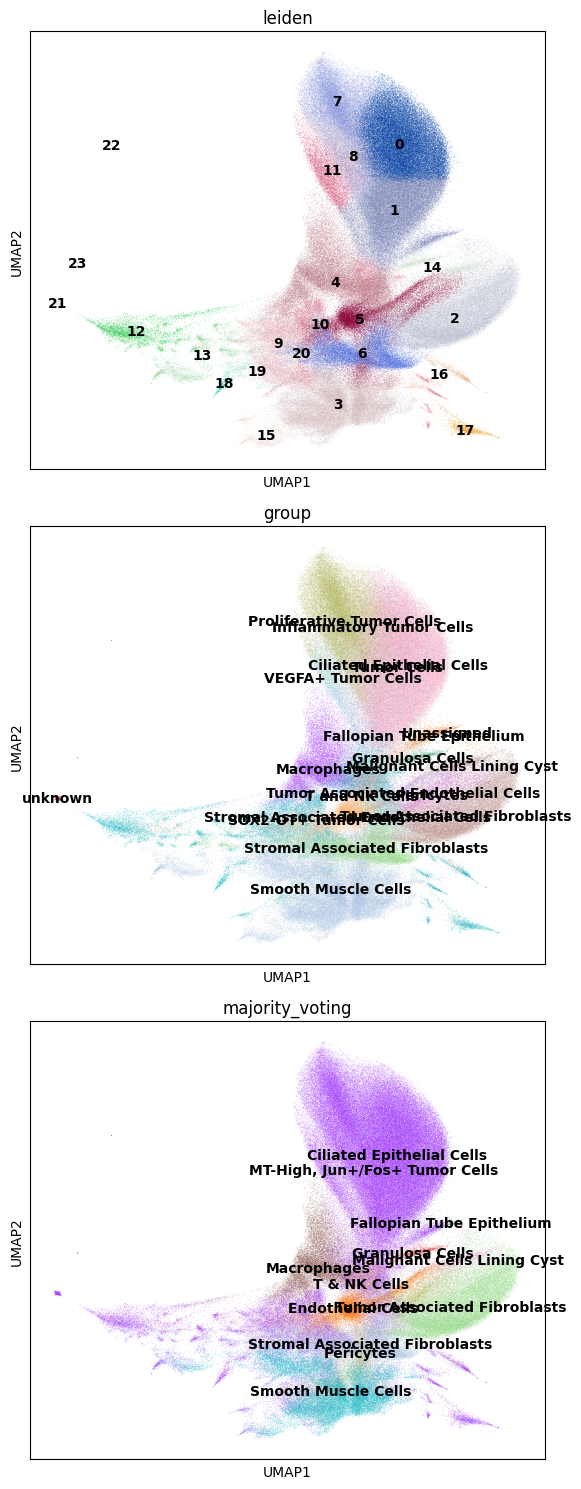

In [76]:
ncols = 1
nrows = 3
width_per_col = 6
height_per_row = 5
wspace = 0.5

# Compute figure size
fig_width = ncols * width_per_col + wspace * (ncols - 1)
fig_height = nrows * height_per_row
figsize = (fig_width, fig_height)

# Create subplot grid
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

# Ensure axs is always iterable (e.g. if nrows=1)
axs = axs.flatten() if nrows > 1 else [axs]

# Plot
sc.pl.umap(xe_data, color='leiden', legend_loc="on data", ax=axs[0], show=False)
sc.pl.umap(xe_data, color='group', legend_loc="on data", ax=axs[1], show=False)
sc.pl.umap(xe_data, color='majority_voting', legend_loc="on data", ax=axs[2], show=False)

plt.tight_layout()
plt.show()

# Load proseg

In [78]:
proseg_obj = xenium(os.path.join(here('02_data/03_processed-data/proseg_xenium')), cells_labels=False, nucleus_boundaries=False)

INFO     reading                                                                                                   
         /fh/fast/_IRC/FHIL/grp/analyses/xenium_cell_annotation/02_data/03_processed-data/proseg_xenium/cell_featur
         e_matrix.h5                                                                                               


/loc/scratch/26236806/ipykernel_13081/1423021724.py:1: DeprecationWarning: The default value of `cells_as_circles` will change to `False` in the next release. Please pass `True` explicitly to maintain the current behavior.
  proseg_obj = xenium(os.path.join(here('02_data/03_processed-data/proseg_xenium')), cells_labels=False, nucleus_boundaries=False)


In [79]:
proseg_obj

SpatialData object
├── Images
│     └── 'morphology_focus': DataTree[cyx] (4, 37631, 54089), (4, 18815, 27044), (4, 9407, 13522), (4, 4703, 6761), (4, 2351, 3380)
├── Labels
│     └── 'nucleus_labels': DataTree[yx] (37631, 54089), (18815, 27044), (9407, 13522), (4703, 6761), (2351, 3380)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 13) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (381820, 1) (2D shapes)
│     └── 'cell_circles': GeoDataFrame shape: (381820, 2) (2D shapes)
└── Tables
      └── 'table': AnnData (381820, 5101)
with coordinate systems:
    ▸ 'global', with elements:
        morphology_focus (Images), nucleus_labels (Labels), transcripts (Points), cell_boundaries (Shapes), cell_circles (Shapes)

In [80]:
proseg_data = proseg_obj.tables['table']

In [81]:
proseg_data.layers["counts"] = proseg_data.X.copy()
sc.pp.normalize_total(proseg_data, target_sum=1e4)
sc.pp.log1p(proseg_data)

In [82]:
proseg_predictions = celltypist.annotate(proseg_data, model, majority_voting=True)

🔬 Input data has 381820 cells and 5101 genes
🔗 Matching reference genes in the model
🧬 4858 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 30
🗳️ Majority voting the predictions
✅ Majority voting done!


In [83]:
proseg_data.obs = pd.merge(
    proseg_data.obs,
    proseg_predictions.predicted_labels,
    left_index=True, right_index=True,
    how='left'
)
proseg_data.obs.head()

,cell_id,transcript_counts,control_probe_counts,genomic_control_counts,control_codeword_counts,unassigned_codeword_counts,deprecated_codeword_counts,total_counts,cell_area,nucleus_area,nucleus_count,segmentation_method,region,z_level,predicted_labels,over_clustering,majority_voting
0,aaaacgmi-1,317,0,0,0,0,0,317,69.0,0.0,0.0,Imported Cell Segmentation,cell_circles,0.0,"MT-High, Jun+/Fos+ Tumor Cells",0,"MT-High, Jun+/Fos+ Tumor Cells"
1,aaaaehpf-1,763,0,0,0,0,0,763,61.0,0.0,0.0,Imported Cell Segmentation,cell_circles,0.0,"MT-High, Jun+/Fos+ Tumor Cells",31,"MT-High, Jun+/Fos+ Tumor Cells"
2,aaaafabo-1,750,0,0,0,0,0,750,343.0,0.0,0.0,Imported Cell Segmentation,cell_circles,0.0,Tumor Associated Fibroblasts,52,Tumor Associated Fibroblasts
3,aaaahakl-1,36,0,0,0,0,0,36,98.0,0.0,0.0,Imported Cell Segmentation,cell_circles,0.0,Tumor Associated Fibroblasts,61,Tumor Associated Fibroblasts
4,aaaamjno-1,607,0,0,0,0,0,607,95.0,0.0,0.0,Imported Cell Segmentation,cell_circles,0.0,"MT-High, Jun+/Fos+ Tumor Cells",90,"MT-High, Jun+/Fos+ Tumor Cells"


In [84]:
sc.pp.neighbors(proseg_data)
sc.tl.umap(proseg_data)
# sc.tl.leiden(proseg_data)